<a href="https://colab.research.google.com/github/amir-asari/AIDroneWorkshop-24-01-2022-/blob/main/BiomehsWorkshop(Part3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 3: Image Classification In Drone Application: Fire Detection


> Now it's time to see one application of AI in drone. Again we will do image classification using CNN through transfer learning approach using VGG16. In this case, we will use the existing dataset in the following link (FLAME dataset)
https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs


> Refer to the following youtube link to watch brief info of FRAME dataset
https://www.youtube.com/watch?v=bHK6g37_KyA





### Modules required

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
!pip install gdown
import gdown
!pip install zipfile
from zipfile import ZipFile

ERROR: Could not find a version that satisfies the requirement zipfile (from versions: none)
ERROR: No matching distribution found for zipfile


## Data preprocessing

We will download the dataset from the provided google drive link. This dataset consists of the folder, `training.zip` and `testing.zip` which will be used as training and testing images. Each folder consists of two folder represent two types of image labels which are 'Fire' and 'No_Fire'

In [2]:
train_download_link = 'https://drive.google.com/u/0/uc?id=1B7BtNlYzPcTqHrl5GuSQ2_3ahKnVVpHY&export=download'
test_download_link = 'https://drive.google.com/u/0/uc?id=1Jvdu2KLH4Fq1UInf-vhfEa0AKyIBx9Dp&export=download'

gdown.download(train_download_link,'Training.zip',quiet=False)

with ZipFile('Training.zip','r') as zipObj:
  zipObj.extractall()

gdown.download(test_download_link,'Test.zip',quiet=False)

with ZipFile('Test.zip','r') as zipObj:
  zipObj.extractall()




Downloading...
From: https://drive.google.com/u/0/uc?id=1B7BtNlYzPcTqHrl5GuSQ2_3ahKnVVpHY&export=download
To: /content/Training.zip
100%|██████████| 1.27G/1.27G [00:12<00:00, 98.1MB/s]
Downloading...
From: https://drive.google.com/u/0/uc?id=1Jvdu2KLH4Fq1UInf-vhfEa0AKyIBx9Dp&export=download
To: /content/Test.zip
100%|██████████| 302M/302M [00:05<00:00, 58.5MB/s]


After that, create a `tf.keras.preprocessing.image.ImageDataGenerator` object which will handle the image dataset for training and testing.

Then the object function called `flow_from_directory` is used provide batch of image dataset according to specification based on function input argument. 

In [10]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator()
test_gen = tf.keras.preprocessing.image.ImageDataGenerator()

names = ["Fire" , "No_Fire"] #make sure the spelling is similar to the folder name
train_batches = train_gen.flow_from_directory(
    'Training',
    target_size = (224,224),
    class_mode = 'sparse', #make label as integer value
    batch_size = 50,
    shuffle = True,
    color_mode = "rgb",
    classes = names
)

test_batches = train_gen.flow_from_directory(
    'Test',
    target_size = (224,224),
    class_mode = 'sparse', #make label as integer value
    batch_size = 50,
    shuffle = True,
    color_mode = "rgb",
    classes = names
)

Found 39375 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


Show the first nine images and labels from the training images (training batches):

(50, 224, 224, 3)
(50,)


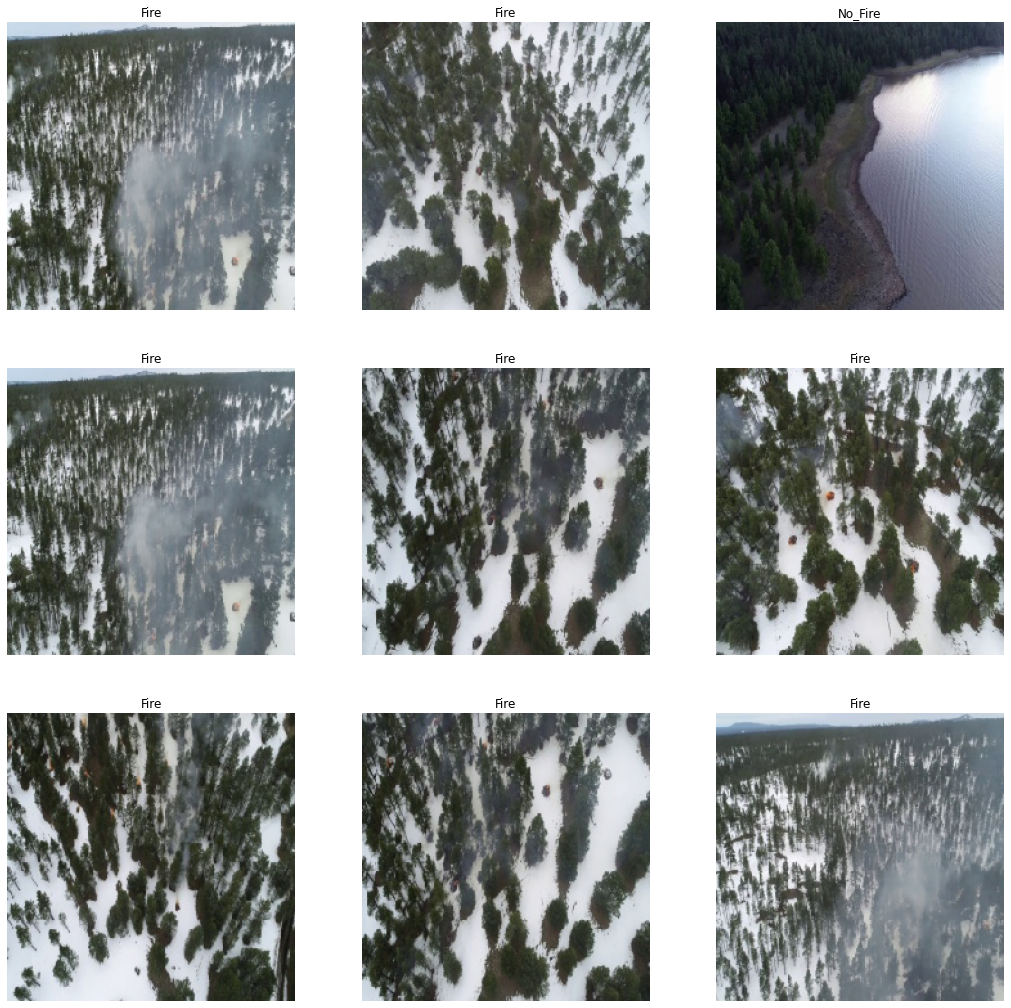

In [11]:
single_train_image_batch = train_batches.next()  #single_train_batch[0] -> image  single_train_batch [1] -> label
batch_images = single_train_image_batch[0]
batch_labels = single_train_image_batch[1]
print(batch_images.shape)
print(batch_labels.shape)

plt.figure(figsize=(18, 18))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(batch_images[i].astype("uint8"))
  plt.title(names[batch_labels[i].astype("int")])
  plt.axis("off")

## Create the CNN model through transfer learning approach using the pre-trained VGG16
You will create the CNN model from the VGG16 model developed at Visual Geometry Group, Univ. of Oxford. This is pre-trained on the ImageNet dataset, a large dataset consisting of over 14 million images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like `jackfruit` and `syringe`. This base of knowledge will help us classify cats and dogs from our specific dataset.

## VGG16 Arhitecture
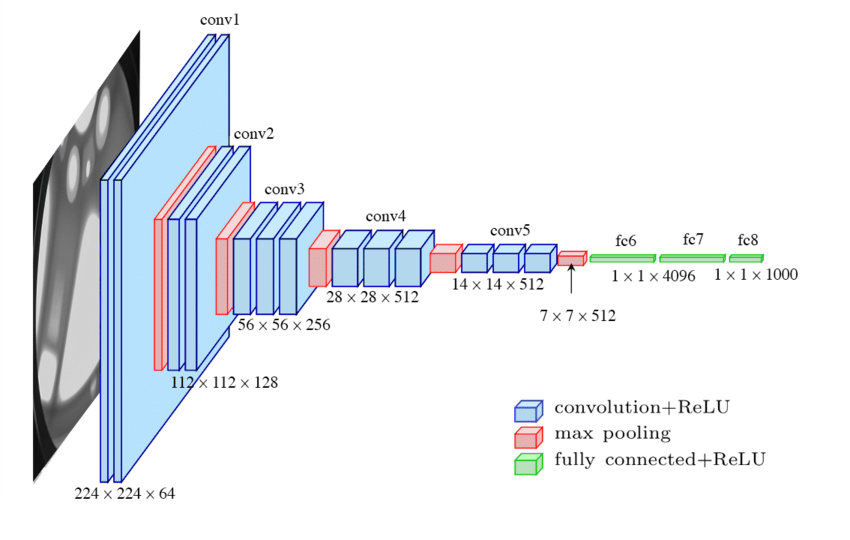

In [5]:
# Create the base model from the pre-trained model MobileNet V2
# IMG_SHAPE = IMG_SIZE + (3,)
# print(IMG_SIZE)
# print(IMG_SHAPE)

base_model = tf.keras.applications.VGG16()
# print(type(base_model))
print("****VGG16 original network arhitecture****")
base_model.summary()

553476096/553467096 [==============================] - 6s 0us/step
****VGG16 original network arhitecture****
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                 

Create new model, copy all layers in VGG16 from the 1st until 2nd last layer

In [6]:
#Create our model by copying from the 1st layer to the 2nd last layer
model = tf.keras.models.Sequential()
for layer in base_model.layers[0:-1]:
  model.add(layer)

print("****model after removing copy all VGG16 layers and remove the last layer****")
model.summary()

****model after removing copy all VGG16 layers and remove the last layer****
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                             

Add the last layer with new dense layer with 2 outputs replacing the dense layer with 1000 outputs

In [7]:
#Freezing the existing weights
for layer in model.layers:
    layer.trainable = False
print(model.summary())

#add new layer which will replace the previous VGG16 last layer
model.add(tf.keras.layers.Dense(2))

print("****model after add new dense layer replacing the previous VGG16 last layer****")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Set Loss and Optimizer Parameter, and Compile with the developed model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

* Loss function - measures how accurate the model is during training, we want to minimize this with the optimizer.
* Optimizer - how the model is updated based on the data it sees and its loss function.
* Metrics - used to monitor the training and testing steps. "accuracy" is the fraction of images that are correctly classified.

In [8]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              metrics = ["accuracy"])

### Train the model

Training the neural network model requires the following steps:

1. Feed the training data to the model—in this example, the `train_batches` which consists of both batches of images and labels.
2. The model learns to associate images and labels.

To start training,  call the `model.fit` method—the model is "fit" to the training data:

In [12]:
model.fit(train_batches,epochs = 1)

788/788 [==============================] - 358s 438ms/step - loss: 0.0139 - accuracy: 0.9951


### Test the model

In [13]:
# print(test_batches.shape)
test_loss, test_acc = model.evaluate(test_batches)

print('Test accuracy:', test_acc)

173/173 [==============================] - 80s 460ms/step - loss: 1.8826 - accuracy: 0.6429
Test accuracy: 0.6429151892662048


Test the developed model in several test images and visual the image, the predicted label, actual label and the probability (in %)

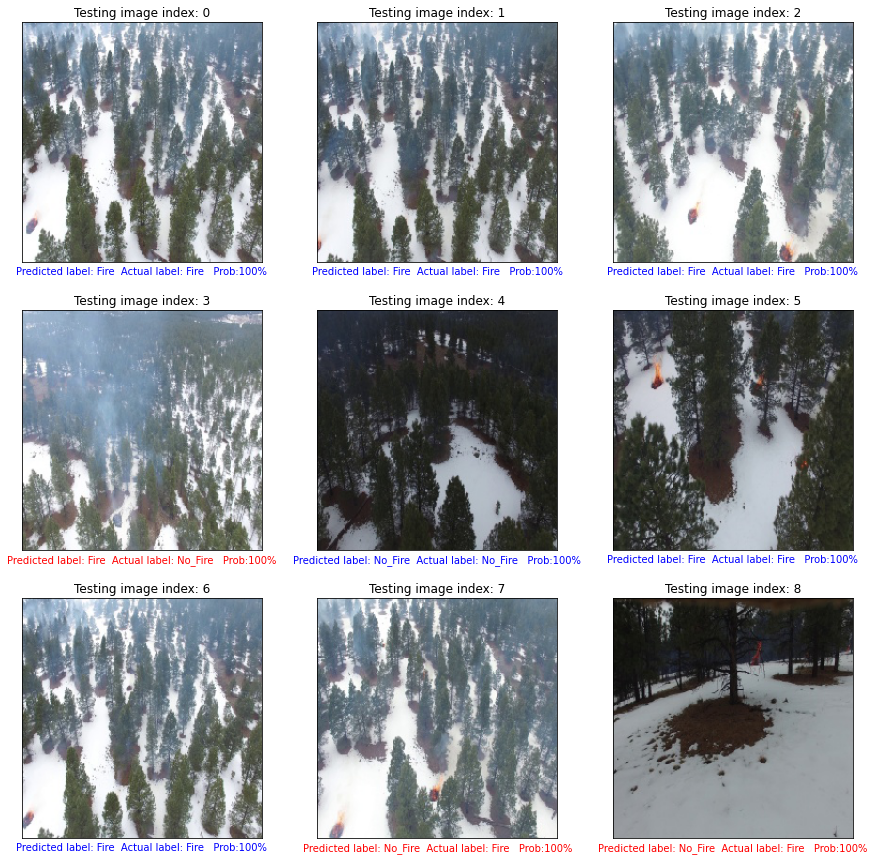

In [14]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i].astype("uint8"), img[i].astype("uint8")
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  predicted_label = np.argmax(predictions_array[i])
  
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("Predicted label: {}  Actual label: {}   Prob:{:2.0f}%".format(names[predicted_label],
                                names[true_label],
                                100*np.max(predictions_array)),
                                color=color)


single_test_image_batch = test_batches.next()
predicted_label_prob = model(single_test_image_batch[0]) # single_test_image_batch[0] -> batches of images; single_test_image_batch[1] -> batches of label
predicted_label_prob = tf.nn.softmax(predicted_label_prob)


plt.figure(figsize=(15, 15))
for index in range(9):
  ax = plt.subplot(3, 3, index + 1)
  plot_image(index,predicted_label_prob,single_test_image_batch[1],single_test_image_batch[0])
  plt.title("Testing image index: {}".format(index))